In [1]:
import pandas as pd
from tqdm import tqdm
import time
import datetime

In [2]:
## 데이터 불러오기
start_time = time.time()
df = pd.read_csv("study_room_HMS.csv")
print("Time : ", time.time() - start_time)

Time :  30.03681445121765


In [3]:
df.shape # 행, 열 갯수 확인

(6962341, 6)

In [4]:
def dfsplit(df):
    start_time = time.time()
    for index, row in tqdm(df.iterrows()):
        yield row.hashed.split(",")
    print("Time : ", time.time() - start_time)

In [5]:
new_hashed = [x for x in dfsplit(df)]# hash 쉼표로 나누기
df.drop(['hashed'], axis=1, inplace=True)
df['hashed'] = new_hashed

6962341it [07:58, 14541.92it/s]


Time :  478.78320145606995


In [6]:
#datetime 형태로 변환
def todatetime(df, col):
    for index, row in tqdm(df.iterrows()):
        t = datetime.datetime.strptime(row[col], "%H:%M:%S.%f")
        yield datetime.datetime.time(t)

In [7]:
starttime = [x for x in todatetime(df, "study_start_time")]
df.drop(['study_start_time'], axis=1, inplace=True)
df['study_start_time'] = starttime

endtime = [x for x in todatetime(df, "study_end_time")]
df.drop(['study_end_time'], axis=1, inplace=True)
df['study_end_time'] = endtime

6962341it [09:43, 11931.37it/s]
6962341it [09:26, 12295.26it/s]


### 파생변수 만들기

변수 만들기 : 이용자 수

In [8]:
nums = [len(df['hashed'][x]) for x in tqdm(range(len(df)))] 
df['number_of_users'] = nums

100%|█████████████████████████████████████████████████████████████████████| 6962341/6962341 [04:26<00:00, 26131.67it/s]


In [9]:
avg_num_user = sum(df['number_of_users']) / len(df) 
print('한번에 함께 이용하는 이용자 수의 평균 :', avg_num_user)

한번에 함께 이용하는 이용자 수의 평균 : 4.924246313129449


변수 만들기 : 이용 시간

In [10]:
def time_difference(df):
    for index, row in tqdm(df.iterrows()):
        yield (datetime.datetime.combine(datetime.date.min, row['study_end_time']) - datetime.datetime.combine(datetime.date.min, row['study_start_time'])).seconds

In [11]:
user_time = [x for x in time_difference(df)]
df['time_difference'] = user_time

6962341it [08:26, 13754.45it/s]


In [12]:
avg_use_time = sum(df['time_difference'] * df['number_of_users']) / sum(df['number_of_users'])
print('인당 평균 이용 시간 :', avg_use_time, 's')

인당 평균 이용 시간 : 1136.6834286919002 s


하루 이용 시간

In [13]:
import matplotlib.pyplot as plt

In [14]:
use_time = pd.DataFrame(columns=['date', 'total_use_time'])
for i in range(1,57):
    total_use_time = sum((df[df['study_start_day'] == i])['number_of_users'] * (df[df['study_start_day'] == i])['time_difference'])
    use_time = use_time.append({'date' : int(i), 'total_use_time' : total_use_time}, ignore_index=True)

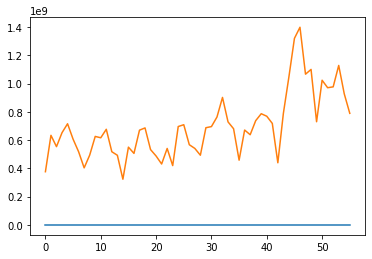

In [15]:
plt.plot(use_time)

In [16]:
# 점점 증가 추세를 보이고 있으며, 일정한 주기를 가지고 오르내리는 형태를 보여주고 있으므로 요일별 변화가 아닌지 확인하기 위해 요일 변수를 추가

In [17]:
use_time['day'] = use_time['date'] % 7 # 변수 추가

In [18]:
(use_time.groupby(['day']).sum())['total_use_time'] 
# 유의미한 차이를 보인다. 특히 day = 1 (start_day_time을 7로 나눈 나머지가 1)일 경우가 많이 낮고 day = 5일 경우가 많이 높다. 
# 하지만 이것만으로는 정확히 언제가 어느 요일인지 알기는 힘들어 보인다.
# 하지만 직관적으로 판단했을때는 이용자수가 가장 적은 day = 1이 일요일로 보는 것이 옳아보이며, 2 = 월요일, 3 = 화요일... 로 예상할 수 있다.

day
0    5325298688
1    3654200411
2    5388857295
3    5455915898
4    6431154314
5    7000441512
6    5714507096
Name: total_use_time, dtype: int64

In [19]:
from collections import Counter
hashed = []
for index, row in df.iterrows():
    for user in row.hashed:
        hashed.append(user)

In [20]:
hashed_df = pd.DataFrame.from_dict(Counter(hashed), orient='index').reset_index()
hashed_df = hashed_df.rename(columns={'index':'hash', 0:'count'})

In [21]:
hashed_df.describe()

,count
count,268148.000000
mean,127.855818
std,257.100419
min,1.000000
25%,3.000000
50%,24.000000
75%,143.000000
max,31498.000000


In [22]:
# 총 268148명의 이용자가 있었으며, 한 사람당의 평균 이용 횟수는 127회였고 가장 많은 횟수를 이용한 이용자의 사용횟수는 31498...인데
# 56일간의 데이터에서 어떻게 저런 사용횟수가 나오는걸까...? 모르겠다..

In [23]:
hashed_df[hashed_df["count"] == 31498]["hash"] # 뭘까...

113147    a183c2b789eb249afbb85c17f7b45886ab5e9a36bc3792...
Name: hash, dtype: object